📘 NOTEBOOK 3 : DATA LOADERS & PIPELINE TESTING
Objectives:
#   - Create TensorFlow data loaders
#   - Implement batching and shuffling
#   - Apply class weights
#   - Test the complete pipeline
#   - Prepare the handoff to the ML Engineer

In [1]:
print("🚀 INITIALIZATION - DATA LOADERS")
print("=" * 70)

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from PIL import Image
import cv2

# Configuration
PREPROCESSED_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/preprocessed'
CONFIG_PATH = '/content/drive/MyDrive/Pneumonia_Project/preprocessing_config.json'
FIGURES_DIR = '/content/drive/MyDrive/Pneumonia_Project/figures'

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

print(f"✅ Imports completed")
print(f"📁 Dataset path: {PREPROCESSED_PATH}")
print(f"🎛️ Image size: {IMG_SIZE}×{IMG_SIZE}")
print(f"📦 Batch size: {BATCH_SIZE}")
print("=" * 70)

🚀 INITIALIZATION - DATA LOADERS
Mounted at /content/drive
✅ Imports completed
📁 Dataset path: /content/drive/MyDrive/Pneumonia_Project/data/preprocessed
🎛️ Image size: 224×224
📦 Batch size: 32


TASK 1: LOAD CONFIGURATION

In [2]:
print("📂 LOADING CONFIGURATION")
print("=" * 70)

# Load config file
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

# Extract information
dataset_stats = config['dataset_stats']
class_weights = config['class_weights']
imbalance_ratio = config['imbalance_ratio']

# Convert class weights (JSON keys are strings)
class_weight_dict = {int(k): v for k, v in class_weights.items()}

print("✅ Configuration loaded successfully")

print(f"\n📊 Dataset Statistics:")
print(f"   Training :   {dataset_stats['NORMAL']['train'] + dataset_stats['PNEUMONIA']['train']} images")
print(f"   Validation : {dataset_stats['NORMAL']['val'] + dataset_stats['PNEUMONIA']['val']} images")
print(f"   Test :       {dataset_stats['NORMAL']['test'] + dataset_stats['PNEUMONIA']['test']} images")

print(f"\n⚖️ Class Weights:")
print(f"   NORMAL (0) :    {class_weight_dict[0]:.3f}")
print(f"   PNEUMONIA (1) : {class_weight_dict[1]:.3f}")

print(f"\n📈 Imbalance Ratio: {imbalance_ratio:.2f}:1")

print("\n" + "=" * 70)


📂 LOADING CONFIGURATION
✅ Configuration loaded successfully

📊 Dataset Statistics:
   Training :   4099 images
   Validation : 878 images
   Test :       879 images

⚖️ Class Weights:
   NORMAL (0) :    1.850
   PNEUMONIA (1) : 0.685

📈 Imbalance Ratio: 2.70:1



TASK 2: CREATE DATA GENERATORS

In [3]:
print("🎨 CREATING DATA GENERATORS")
print("=" * 70)

# Data Generator for TRAINING (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalization
    rotation_range=15,           # Rotation ±15°
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom
    horizontal_flip=True,        # Horizontal flip
    fill_mode='nearest'
)

# Data Generator for VALIDATION and TEST (without augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Data generators created")

print("\n📋 TRAINING Configuration:")
print("   • Augmentation: YES")
print("   • Normalization: [0–1]")
print("   • Transformations: rotation, shift, shear, zoom, flip")

print("\n📋 VALIDATION/TEST Configuration:")
print("   • Augmentation: NO")
print("   • Normalization: [0–1]")

# Create flow_from_directory
print("\n🔄 Creating data flows...")

# Training generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(PREPROCESSED_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',           # Binary classification
    color_mode='grayscale',        # Grayscale images
    shuffle=True,                  # Shuffle at each epoch
    seed=SEED
)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(PREPROCESSED_PATH, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,                 # Do not shuffle (important!)
    seed=SEED
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(PREPROCESSED_PATH, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,                 # Do not shuffle (important!)
    seed=SEED
)

print("\n✅ Data flows created")

print(f"\n📊 Training generator:")
print(f"   • Total batches: {len(train_generator)}")
print(f"   • Images per batch: {BATCH_SIZE}")
print(f"   • Total images: {train_generator.samples}")
print(f"   • Classes: {train_generator.class_indices}")

print(f"\n📊 Validation generator:")
print(f"   • Total batches: {len(val_generator)}")
print(f"   • Total images: {val_generator.samples}")

print(f"\n📊 Test generator:")
print(f"   • Total batches: {len(test_generator)}")
print(f"   • Total images: {test_generator.samples}")

print("\n" + "=" * 70)


🎨 CREATING DATA GENERATORS
✅ Data generators created

📋 TRAINING Configuration:
   • Augmentation: YES
   • Normalization: [0–1]
   • Transformations: rotation, shift, shear, zoom, flip

📋 VALIDATION/TEST Configuration:
   • Augmentation: NO
   • Normalization: [0–1]

🔄 Creating data flows...
Found 4099 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 879 images belonging to 2 classes.

✅ Data flows created

📊 Training generator:
   • Total batches: 129
   • Images per batch: 32
   • Total images: 4099
   • Classes: {'NORMAL': 0, 'PNEUMONIA': 1}

📊 Validation generator:
   • Total batches: 28
   • Total images: 878

📊 Test generator:
   • Total batches: 28
   • Total images: 879



TASK 3: TEST DATA LOADERS

🧪 TESTING DATA LOADERS

📦 Loading one training batch...

✅ Batch loaded successfully
   Image shape: (32, 224, 224, 1)
   Label shape: (32,)
   Data type: float32
   Image value range: [0.0000, 1.0000]
   Unique labels: [0. 1.]

📊 Distribution in this batch:
   NORMAL (0):    9 (28.1%)
   PNEUMONIA (1): 23 (71.9%)

💾 Saved: /content/drive/MyDrive/Pneumonia_Project/figures/08_batch_examples.png


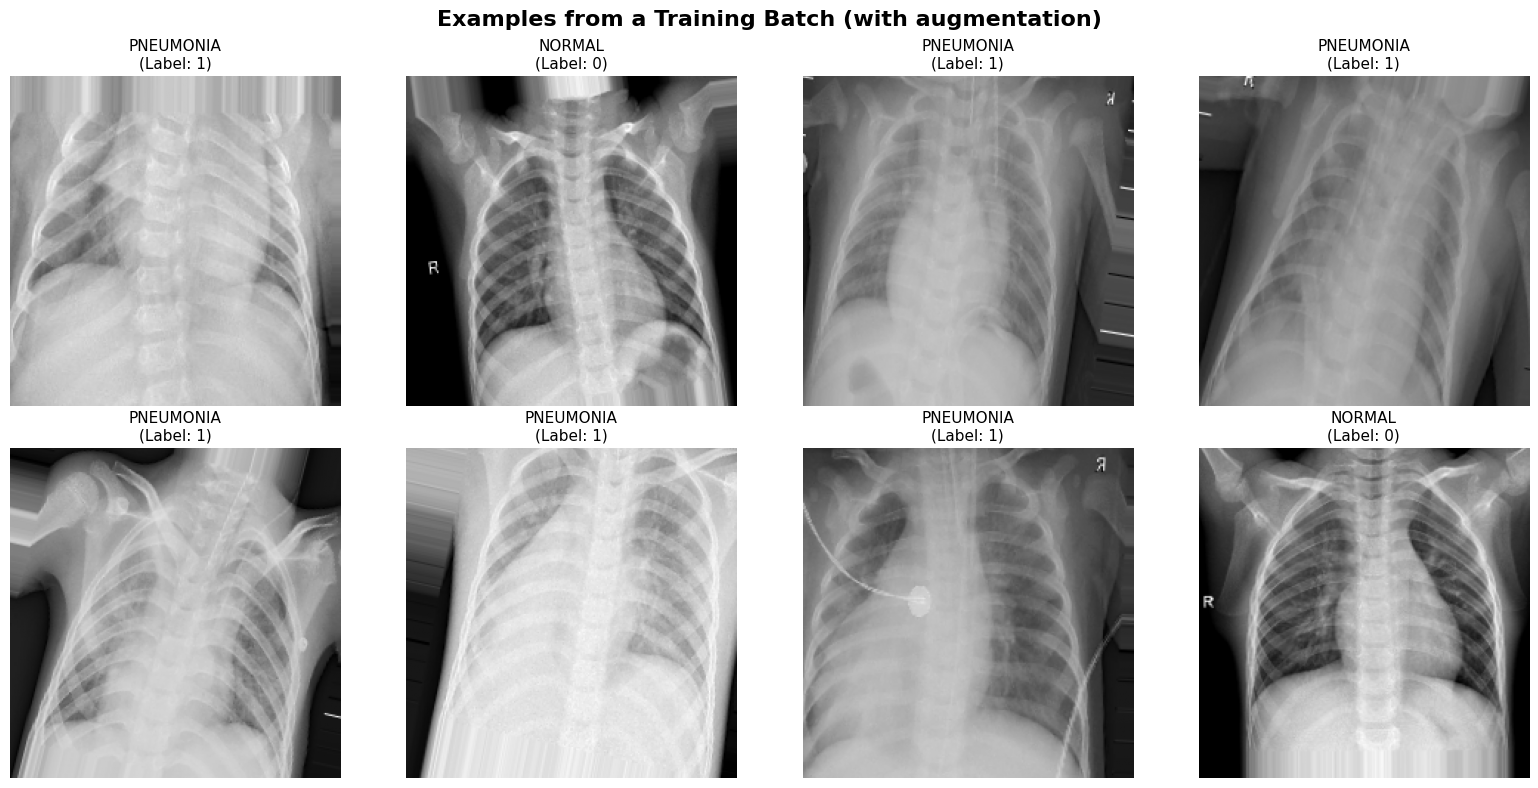


✅ Data loaders are working correctly


In [4]:
print("🧪 TESTING DATA LOADERS")
print("=" * 70)

# Load one training batch
print("\n📦 Loading one training batch...")
batch_images, batch_labels = next(train_generator)

print(f"\n✅ Batch loaded successfully")
print(f"   Image shape: {batch_images.shape}")
print(f"   Label shape: {batch_labels.shape}")
print(f"   Data type: {batch_images.dtype}")
print(f"   Image value range: [{batch_images.min():.4f}, {batch_images.max():.4f}]")
print(f"   Unique labels: {np.unique(batch_labels)}")

# Check label distribution inside the batch
n_normal = np.sum(batch_labels == 0)
n_pneumonia = np.sum(batch_labels == 1)

print(f"\n📊 Distribution in this batch:")
print(f"   NORMAL (0):    {n_normal} ({100*n_normal/BATCH_SIZE:.1f}%)")
print(f"   PNEUMONIA (1): {n_pneumonia} ({100*n_pneumonia/BATCH_SIZE:.1f}%)")

# Visualize some images from the batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Examples from a Training Batch (with augmentation)',
             fontsize=16, fontweight='bold')

for i in range(8):
    ax = axes[i//4, i%4]
    img = batch_images[i].squeeze()
    label = batch_labels[i]
    label_name = 'NORMAL' if label == 0 else 'PNEUMONIA'

    ax.imshow(img, cmap='gray')
    ax.set_title(f'{label_name}\n(Label: {int(label)})', fontsize=11)
    ax.axis('off')

plt.tight_layout()

save_path = os.path.join(FIGURES_DIR, '08_batch_examples.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved: {save_path}")

plt.show()

print("\n" + "=" * 70)
print("✅ Data loaders are working correctly")
print("=" * 70)


TASK 4: CLASS WEIGHT CONFIGURATION

In [5]:

print("⚖️ CONFIGURING CLASS WEIGHTS FOR TRAINING")
print("=" * 70)

# Class weights are already loaded in class_weight_dict
print(f"\n📊 Class Weights to use during training:")
print(f"   class_weight = {class_weight_dict}")

print(f"\n💡 How to use them in the model:")
print("""
# Inside the ML Engineer's training script:

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight={0: 1.850, 1: 0.685},  # ← Class weights applied here!
    callbacks=[...]
)
""")

print(f"\n✅ Configuration ready for training")
print("\n" + "=" * 70)


⚖️ CONFIGURING CLASS WEIGHTS FOR TRAINING

📊 Class Weights to use during training:
   class_weight = {0: 1.8497292418772564, 1: 0.6852223336676697}

💡 How to use them in the model:

# Inside the ML Engineer's training script:

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight={0: 1.850, 1: 0.685},  # ← Class weights applied here!
    callbacks=[...]
)


✅ Configuration ready for training



TASK 5: COMPLETE PIPELINE STATISTICS

📊 COMPLETE PIPELINE STATISTICS

🔄 Analyzing distribution (may take 1-2 minutes)...
   Analyzing training set...
   Analyzing validation set...
   Analyzing test set...

✅ Analysis completed

📊 FINAL DISTRIBUTION:
----------------------------------------------------------------------
     Split     Class  Count
  Training    NORMAL   1108
  Training PNEUMONIA   2991
Validation    NORMAL    237
Validation PNEUMONIA    641
      Test    NORMAL    238
      Test PNEUMONIA    641

💾 Saved: /content/drive/MyDrive/Pneumonia_Project/figures/09_loader_distribution.png


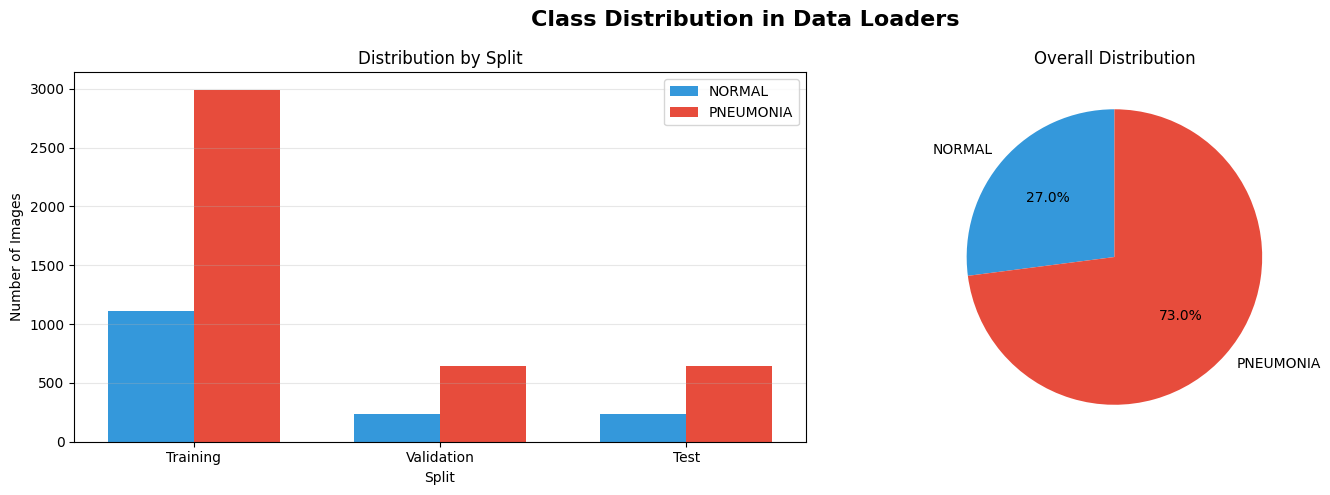

In [6]:

print("📊 COMPLETE PIPELINE STATISTICS")
print("=" * 70)

# Function to count images per class in a generator
def get_class_distribution(generator):
    """Get the class distribution"""
    labels = []
    for i in range(len(generator)):
        _, batch_labels = generator[i]
        labels.extend(batch_labels)

    labels = np.array(labels)
    n_normal = np.sum(labels == 0)
    n_pneumonia = np.sum(labels == 1)

    return n_normal, n_pneumonia

print("\n🔄 Analyzing distribution (may take 1-2 minutes)...")

# Training
print("   Analyzing training set...")
train_normal, train_pneumonia = get_class_distribution(train_generator)

# Validation
print("   Analyzing validation set...")
val_normal, val_pneumonia = get_class_distribution(val_generator)

# Test
print("   Analyzing test set...")
test_normal, test_pneumonia = get_class_distribution(test_generator)

# Reset generators after analysis
train_generator.reset()
val_generator.reset()
test_generator.reset()

print("\n✅ Analysis completed")

# Create a DataFrame for visualization
data = {
    'Split': ['Training', 'Training', 'Validation', 'Validation', 'Test', 'Test'],
    'Class': ['NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA'],
    'Count': [train_normal, train_pneumonia, val_normal, val_pneumonia, test_normal, test_pneumonia]
}

df = pd.DataFrame(data)

print("\n📊 FINAL DISTRIBUTION:")
print("-" * 70)
print(df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Class Distribution in Data Loaders',
             fontsize=16, fontweight='bold')

# Bar chart per split
splits = ['Training', 'Validation', 'Test']
normal_counts = [train_normal, val_normal, test_normal]
pneumonia_counts = [train_pneumonia, val_pneumonia, test_pneumonia]

x = np.arange(len(splits))
width = 0.35

axes[0].bar(x - width/2, normal_counts, width, label='NORMAL', color='#3498db')
axes[0].bar(x + width/2, pneumonia_counts, width, label='PNEUMONIA', color='#e74c3c')
axes[0].set_xlabel('Split')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Distribution by Split')
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Pie chart (overall distribution)
total_normal = train_normal + val_normal + test_normal
total_pneumonia = train_pneumonia + val_pneumonia + test_pneumonia

axes[1].pie([total_normal, total_pneumonia],
            labels=['NORMAL', 'PNEUMONIA'],
            autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'],
            startangle=90)
axes[1].set_title('Overall Distribution')

plt.tight_layout()

save_path = os.path.join(FIGURES_DIR, '09_loader_distribution.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved: {save_path}")

plt.show()

print("\n" + "=" * 70)


TASK 6: PIPELINE PERFORMANCE TEST

In [7]:
import time

print("⚡ PIPELINE PERFORMANCE TEST")
print("=" * 70)

# Loading speed test
print("\n🏃 Measuring loading speed...")

# Measure the time to load 10 batches
n_batches_test = 10
start_time = time.time()

for i in range(n_batches_test):
    batch_images, batch_labels = next(train_generator)

elapsed_time = time.time() - start_time
avg_time_per_batch = elapsed_time / n_batches_test

print(f"\n✅ Performance test results:")
print(f"   Total time: {elapsed_time:.2f} seconds")
print(f"   Time per batch: {avg_time_per_batch:.3f} seconds")
print(f"   Images/sec: {BATCH_SIZE / avg_time_per_batch:.1f}")

# Estimate time for one full epoch
batches_per_epoch = len(train_generator)
estimated_epoch_time = batches_per_epoch * avg_time_per_batch

print(f"\n📊 Estimated time for a full epoch:")
print(f"   Batches/epoch: {batches_per_epoch}")
print(f"   Estimated time: {estimated_epoch_time:.1f} seconds ({estimated_epoch_time/60:.1f} minutes)")

# Reset the generator
train_generator.reset()

print("\n💡 Recommendations:")
if avg_time_per_batch < 0.5:
    print("   ✅ Excellent performance – pipeline is optimized")
elif avg_time_per_batch < 1.0:
    print("   ✅ Good performance – acceptable for training")
else:
    print("   ⚠️  Slow performance – consider optimizations")

print("\n" + "=" * 70)


⚡ PIPELINE PERFORMANCE TEST

🏃 Measuring loading speed...

✅ Performance test results:
   Total time: 4.18 seconds
   Time per batch: 0.418 seconds
   Images/sec: 76.6

📊 Estimated time for a full epoch:
   Batches/epoch: 129
   Estimated time: 53.9 seconds (0.9 minutes)

💡 Recommendations:
   ✅ Excellent performance – pipeline is optimized



TASK 7: PACKAGE FOR THE ML ENGINEER

In [8]:
print("📦 CREATING PACKAGE FOR THE ML ENGINEER")
print("=" * 70)

# Create a Python file containing all the necessary code
ml_package_code = """
# ═══════════════════════════════════════════════════════════
# DATA LOADING PACKAGE - PNEUMONIA DETECTION
# Data Engineer: Bouhmidi Amina Meroua
# ═══════════════════════════════════════════════════════════

import os
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class PneumoniaDataLoader:
    \"\"\"
    Data loader for the Pneumonia Detection project

    Usage:
        loader = PneumoniaDataLoader(base_path)
        train_gen, val_gen, test_gen, class_weights = loader.get_generators()

        model.fit(
            train_gen,
            validation_data=val_gen,
            class_weight=class_weights,
            ...
        )
    \"\"\"

    def __init__(self, base_path, img_size=224, batch_size=32, seed=42):
        self.base_path = base_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.seed = seed

        # Load configuration
        config_path = os.path.join(
            os.path.dirname(base_path),
            'preprocessing_config.json'
        )
        with open(config_path, 'r') as f:
            self.config = json.load(f)

        # Extract class weights
        self.class_weights = {
            int(k): v for k, v in self.config['class_weights'].items()
        }

    def get_generators(self):
        \"\"\"
        Returns data generators for train, val, test

        Returns:
            train_generator, val_generator, test_generator, class_weights
        \"\"\"
        # Training generator (with augmentation)
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Validation/Test generator (no augmentation)
        val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Create the flows
        train_generator = train_datagen.flow_from_directory(
            os.path.join(self.base_path, 'train'),
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            color_mode='grayscale',
            shuffle=True,
            seed=self.seed
        )

        val_generator = val_test_datagen.flow_from_directory(
            os.path.join(self.base_path, 'val'),
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            color_mode='grayscale',
            shuffle=False,
            seed=self.seed
        )

        test_generator = val_test_datagen.flow_from_directory(
            os.path.join(self.base_path, 'test'),
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            color_mode='grayscale',
            shuffle=False,
            seed=self.seed
        )

        return train_generator, val_generator, test_generator, self.class_weights


# ═══════════════════════════════════════════════════════════
# EXAMPLE USAGE
# ═══════════════════════════════════════════════════════════

if __name__ == "__main__":
    # Initialize the loader
    loader = PneumoniaDataLoader(
        base_path='/content/drive/MyDrive/Pneumonia_Project/data/preprocessed',
        img_size=224,
        batch_size=32
    )

    # Get generators
    train_gen, val_gen, test_gen, class_weights = loader.get_generators()

    print("✅ Data loaders created")
    print(f"📊 Training samples: {train_gen.samples}")
    print(f"📊 Validation samples: {val_gen.samples}")
    print(f"📊 Test samples: {test_gen.samples}")
    print(f"⚖️  Class weights: {class_weights}")
"""

# Save the file
package_path = '/content/drive/MyDrive/Pneumonia_Project/data_loader.py'
with open(package_path, 'w') as f:
    f.write(ml_package_code)

print(f"✅ Package created: {package_path}")

print("\n📋 File created: data_loader.py")
print("\n💡 The ML Engineer can now use:")
print("""
from data_loader import PneumoniaDataLoader

loader = PneumoniaDataLoader(base_path='...')
train_gen, val_gen, test_gen, class_weights = loader.get_generators()

model.fit(
    train_gen,
    validation_data=val_gen,
    class_weight=class_weights,
    epochs=50
)
""")

print("\n" + "=" * 70)


📦 CREATING PACKAGE FOR THE ML ENGINEER
✅ Package created: /content/drive/MyDrive/Pneumonia_Project/data_loader.py

📋 File created: data_loader.py

💡 The ML Engineer can now use:

from data_loader import PneumoniaDataLoader

loader = PneumoniaDataLoader(base_path='...')
train_gen, val_gen, test_gen, class_weights = loader.get_generators()

model.fit(
    train_gen,
    validation_data=val_gen,
    class_weight=class_weights,
    epochs=50
)




FINAL SUMMARY

In [9]:
print("\n" + "=" * 70)
print("🎉 DATA LOADERS – FINAL REPORT")
print("=" * 70)

print("\n✅ DELIVERABLES CREATED:")
print("-" * 70)
print(f"   1. Training generator :   {train_generator.samples} images")
print(f"   2. Validation generator : {val_generator.samples} images")
print(f"   3. Test generator :       {test_generator.samples} images")
print(f"   4. Class weights :        {class_weight_dict}")
print(f"   5. Python package :       data_loader.py")
print(f"   6. Figures (08-09) :      {FIGURES_DIR}/")

print("\n📊 FINAL CONFIGURATION:")
print("-" * 70)
print(f"   Image size :    {IMG_SIZE}×{IMG_SIZE}")
print(f"   Batch size :    {BATCH_SIZE}")
print(f"   Color mode :    Grayscale")
print(f"   Augmentation :  Training only")
print(f"   Shuffling :     Training only")

print("\n⚡ PERFORMANCE:")
print("-" * 70)
print(f"   Time per batch :   ~{avg_time_per_batch:.3f} seconds")
print(f"   Images/sec :       ~{BATCH_SIZE / avg_time_per_batch:.1f}")
print(f"   Time per epoch :   ~{estimated_epoch_time/60:.1f} minutes")

print("\n🎯 READY FOR TRAINING:")
print("-" * 70)
print("   ✅ Data loaders configured")
print("   ✅ Augmentation applied (training)")
print("   ✅ Class weights calculated (1.850 / 0.685)")
print("   ✅ Pipeline tested and validated")
print("   ✅ Python package created")

print("\n📝 HANDOFF TO ML ENGINEER:")
print("-" * 70)
print("""
   The ML Engineer now has access to:

   1. Preprocessed dataset (5,856 images, 70/15/15 split)
   2. Ready-to-use data loaders
   3. Optimized class weights
   4. Reusable Python package
   5. Complete documentation

   Training can start immediately!
""")

print("=" * 70)
print("💪 DAYS 5-6: SUCCESSFULLY COMPLETED")
print("🎓 DATA ENGINEERING PHASE: 100% COMPLETE")
print("=" * 70)

# Save final summary
final_summary = {
    "phase": "Data Loaders – Days 5-6",
    "status": "COMPLETE",
    "generators": {
        "training": train_generator.samples,
        "validation": val_generator.samples,
        "test": test_generator.samples
    },
    "configuration": {
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "color_mode": "grayscale",
        "augmentation": "training_only"
    },
    "class_weights": class_weight_dict,
    "performance": {
        "time_per_batch_sec": round(avg_time_per_batch, 3),
        "images_per_sec": round(BATCH_SIZE / avg_time_per_batch, 1),
        "time_per_epoch_min": round(estimated_epoch_time / 60, 1)
    },
    "deliverables": [
        "Training/Val/Test generators",
        "Class weights",
        "Python package (data_loader.py)",
        "Performance metrics",
        "Documentation"
    ]
}

summary_path = '/content/drive/MyDrive/Pneumonia_Project/data_loaders_summary.json'
with open(summary_path, 'w') as f:
    json.dump(final_summary, f, indent=2)

print(f"\n💾 Summary saved: {summary_path}")



🎉 DATA LOADERS – FINAL REPORT

✅ DELIVERABLES CREATED:
----------------------------------------------------------------------
   1. Training generator :   4099 images
   2. Validation generator : 878 images
   3. Test generator :       879 images
   4. Class weights :        {0: 1.8497292418772564, 1: 0.6852223336676697}
   5. Python package :       data_loader.py
   6. Figures (08-09) :      /content/drive/MyDrive/Pneumonia_Project/figures/

📊 FINAL CONFIGURATION:
----------------------------------------------------------------------
   Image size :    224×224
   Batch size :    32
   Color mode :    Grayscale
   Augmentation :  Training only
   Shuffling :     Training only

⚡ PERFORMANCE:
----------------------------------------------------------------------
   Time per batch :   ~0.418 seconds
   Images/sec :       ~76.6
   Time per epoch :   ~0.9 minutes

🎯 READY FOR TRAINING:
----------------------------------------------------------------------
   ✅ Data loaders configured
   ✅